In [58]:
import pandas as pd
import spacy
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#train_set = pd.read_csv(filepath_or_buffer='./Dataset/train.csv', sep=',')
test_set = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/apt/Dataset/test.csv', sep=',')
# sample_submission_set = pd.read_csv(filepath_or_buffer='./Dataset/sampleSubmission.csv', sep=',')

In [60]:
nlp = spacy.load("en_core_web_sm")

In [61]:
print(test_set["product_title"][152])
print(test_set["product_description"][152])

Cotton Tale Sidekick Pillow Pack
Add some chic rural accents to your little one's nursery with these gorgeous Cotton Tale pillows. Three different sizes and bold patterns make these pillows the perfect choice for your little cowgirl or boy. 

Set includes: Three (3) decorative pilllows
Small pillow: 10 inches x 10 inches
Medium pillow: 12 inches x 12 inches
Large pillow: 15 inches x 15 inches
Gender: Neutral
Pattern: Western, cowboy chic
Materials: Cotton, polyfill
Care instructions: Spot clean only
Imported


In [62]:
def preprocess_text(df, include_digit = 0):
    #include_digits = 0 --> don't remove any tokens with digits
    #include_digits = 1 --> remove tokens which all characters are digits
    #include_digits = 2 --> remove all tokens which contain digits

    product_all_preprocessed = []
    query_all_preprocessed = []
    
    for idx, row in df.iterrows():
        product_preprocessed = []
        query_preprocessed = []
        product = row['product']
        query = row['query']

        product = ' '.join(product.split())
        query = ' '.join(query.split())
            
        doc_product = nlp(product)
        doc_query = nlp(query)

        query_tokens = [str(token) for sent in doc_query.sents for token in sent]

        for sent in doc_product.sents: 
            for token in sent:
                if not token.is_stop and not token.is_punct:
                    if (include_digit == 0) \
                        or (include_digit == 1 and not all(map(str.isdigit, str(token)))) \
                        or (include_digit == 2 and not any(map(str.isdigit, str(token)))) \
                        or str(token) in query_tokens:
                        product_preprocessed.append(str.lower(token.lemma_))

        for sent in doc_query.sents: 
            for token in sent:
                if not token.is_stop and not token.is_punct:
                    query_preprocessed.append(str.lower(token.lemma_))

                    

        product_all_preprocessed.append(" ".join(map(str, product_preprocessed)))
        query_all_preprocessed.append(" ".join(map(str, query_preprocessed)))
        
    df['query'] = query_all_preprocessed
    df['product'] = product_all_preprocessed
    
    return df

In [63]:
#spajamo naslov i opis produkta u 1 stupac kako bi ih mogli zajedno pretprocesirat
def get_df_for_preprocessing():
    df = pd.DataFrame(test_set)
    df = df.replace(np.nan, '', regex=True)
    df['queryOrig']=df['query']
    df['productTOrig']=df["product_title"]
    df['productDOrig']=df["product_description"]
    df['product'] = df["product_title"] + " " + df["product_description"]

    return df

In [64]:
df_preprocessed = get_df_for_preprocessing()
df_preprocessed = preprocess_text(df_preprocessed, 0)

In [65]:
df_preprocessed.to_csv(r'/content/drive/MyDrive/Colab Notebooks/apt/Dataset/dataframes/df_preprocessed_test_with_numbers.csv', encoding='utf-8', header='true')

In [121]:
import gensim
from gensim.models import Word2Vec
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
import codecs, json 
import nltk
nltk.download('punkt')
import numpy as np

with open("/content/drive/MyDrive/Colab Notebooks/apt/Dataset/dataframes/df_preprocessed_test_with_numbers.csv", 'r') as f:
  df_preprocessed = pd.read_csv(filepath_or_buffer=f, sep=',')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [122]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)
model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [123]:
def get_vector_average(words):
  vectors = 0
  numOfExceptableWords = 0  #ukupni broj rijeci za koje cemo izgenerirati vektore
  for w in words:
    try:                    #ako neka rijec ne postoji u vokabularu baca se iznimka
      vec = model.wv[w]
      vectors += vec
      numOfExceptableWords +=1
    except:
      continue
  
  listV=list()
  if(numOfExceptableWords==0): 
    for i in range(300):
      listV.append(str(0.0))
  else: 
    vecM=vectors/numOfExceptableWords
    for v in vecM:
      listV.append(str(v))
    
  return listV

In [124]:
d= {'id': [], 'query_vector': [], 'product_vector': [], 'queryOrig': [], 'productTOrig': [], 'productDOrig': []}
df_pp_vectors = pd.DataFrame(data=d)

query_average = []
products_average = []
ids = []
query_original=[]
product_title_original=[]
product_desc_original=[]

 
for i, item in df_preprocessed.iterrows():
  ids.append(item["id"])
  query_words = item["query"].split()
  product_words = item["product"].split()
  
  query_average.append(get_vector_average(item["query"].split()))
  products_average.append(get_vector_average(item["product"].split()))

  query_original.append(item["queryOrig"])
  product_title_original.append(item["productTOrig"])
  product_desc_original.append(item["productDOrig"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [125]:
df_pp_vectors['id']=ids
df_pp_vectors['query_vector']=query_average
df_pp_vectors['product_vector']=products_average
df_pp_vectors['queryOrig']=query_original
df_pp_vectors['productTOrig']=product_title_original
df_pp_vectors['productDOrig']=product_desc_original

In [126]:
df = {}
df["entity"] = list()
for i, o in df_pp_vectors.iterrows(): 
  df["entity"].append({
         "id": o.id,
         "query_vector": o.query_vector,
         "product_vector": o.product_vector,
         "queryOrig":o.queryOrig,
         "productTOrig":o.productTOrig,
         "productDOrig":o.productDOrig
  })

with open('/content/drive/MyDrive/Colab Notebooks/apt/word2vec_test_with_numbers.json', 'w') as outfile:
  json.dump(list(df["entity"]),outfile,indent=3)

In [127]:
import pandas as pd
import json
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt

In [128]:
def error(pred):
  rounded=[round(x) for x in pred]
  rounded=[1 if x<1 else x for x in rounded]
  rounded=[4 if x>4 else x for x in rounded]
  errors=list()
  for p, r in zip(pred, rounded):
    errors.append(MSE([r], [p]))
  return errors

In [129]:
#tu bi trebao umjesto ovoga ici load najboljeg modela
def accuracy(real, pred):
  pred=[round(x) for x in pred]
  pred=[1 if x<1 else x for x in pred]
  pred=[4 if x>4 else x for x in pred]
  s=np.sum(pred == real)
  return s/len(pred)

data  = []
with open("/content/drive/MyDrive/Colab Notebooks/apt/word2vec_without_numbers.json", 'r') as f:
    data=json.load(f)
    without_numbers = pd.DataFrame(data)

print(without_numbers.head(1))

query = np.array([np.array(list(np.float_(x))) for x in without_numbers['query_vector']])
product = np.array([np.array(list(np.float_(x))) for x in without_numbers['product_vector']])
label = np.array(without_numbers['median_relevance'])

train = [np.concatenate((query, product), axis = 1)]

for tr in train:
    X_train, X_test, y_train, y_test = train_test_split(tr, label, test_size=0.4, random_state=42)
    model = SVR(kernel = 'linear').fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(MAE(y_test, prediction), MSE(y_test, prediction))
    print(accuracy(y_test, prediction))

   id                                       query_vector  \
0   1  [-0.067871094, 0.122558594, -0.17480469, 0.086...   

                                      product_vector  median_relevance  \
0  [0.010758463, 0.015542602, 0.008837891, 0.0595...                 1   

   relevance_variance  
0                 0.0  
0.5949937826673509 0.7912099329496702
0.5868602362204725


In [132]:
data  = []
with open("/content/drive/MyDrive/Colab Notebooks/apt/word2vec_test_with_numbers.json", 'r') as f:
    data=json.load(f)
    with_numbers = pd.DataFrame(data)

query = np.array([np.array(list(np.float_(x))) for x in with_numbers['query_vector']])
product = np.array([np.array(list(np.float_(x))) for x in with_numbers['product_vector']])
test=np.concatenate((query, product), axis = 1)

predictionAll = model.predict(test)

In [150]:
from prettytable import PrettyTable
goodExamplesIndex=[4988, 1, 5001, 12, 5006, 35, 5011, 56, 5016, 61, 5018, 62, 5084, 75, 79, 80]
goodExamples=with_numbers.iloc[goodExamplesIndex]
query = np.array([np.array(list(np.float_(x))) for x in goodExamples['query_vector']])
product = np.array([np.array(list(np.float_(x))) for x in goodExamples['product_vector']])
testGood=np.concatenate((query, product), axis = 1)
predictionGood = model.predict(testGood)
c=0
t = PrettyTable(['prediction', 'query', 'product title', 'product description'])
t.align['query'] = "l"
t.align['product title'] = "l"
t.align['product description'] = "l"
for i, item in goodExamples.iterrows():
  t.add_row([predictionGood[c], item['queryOrig'], item['productTOrig'], str(item['productDOrig']).replace("\n", "\t").replace("nan", "")])
  c+=1
print(t)

+--------------------+---------------------------+---------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     prediction     | query                     | product title                                                                   | product description                                                                                                   

In [151]:
badExamplesIndex=[5003, 20, 5029, 31, 5059, 54, 5069, 58, 5089, 64, 5103, 74, 5107, 77, 90, 92, 94]
badExamples=with_numbers.iloc[badExamplesIndex]
query = np.array([np.array(list(np.float_(x))) for x in badExamples['query_vector']])
product = np.array([np.array(list(np.float_(x))) for x in badExamples['product_vector']])
testBad=np.concatenate((query, product), axis = 1)
predictionBad = model.predict(testBad)
c=0
t = PrettyTable(['prediction', 'query', 'product title', 'product description'])
t.align['query'] = "l"
t.align['product title'] = "l"
t.align['product description'] = "l"
for i, item in badExamples.iterrows():
  t.add_row([predictionBad[c], item['queryOrig'], item['productTOrig'], str(item['productDOrig']).replace("\n", "\t").replace("nan", "")])
  c+=1
print(t)

+--------------------+----------------------------+------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     prediction     | query                      | product title                                                                                                          | p

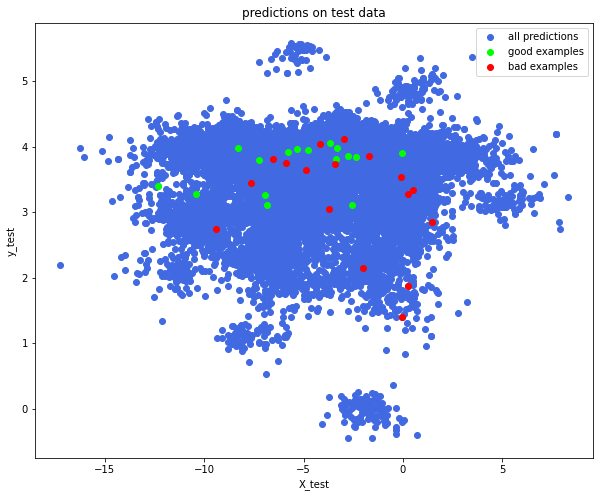

In [156]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 8))
X_grid = np.arange(min(np.sum(X_test, axis=1)), max(np.sum(X_test, axis=1)), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(np.sum(test, axis=1), predictionAll, color = 'royalblue', label='all predictions')
plt.scatter(np.sum(testGood, axis=1), predictionGood, color = 'lime', label='good examples')
plt.scatter(np.sum(testBad, axis=1), predictionBad, color = 'red', label='bad examples')
plt.title('predictions on test data')
plt.xlabel('X_test')
plt.ylabel('y_test')
plt.legend(loc="best")
plt.show()